In [1]:
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout, TimeDistributed, BatchNormalization, Flatten, Activation
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import numpy as np
import h5py
import matplotlib.pyplot as plt
from data_utils import get_data
from sklearn import preprocessing
from functools import reduce
from scipy.fftpack import dct, idct
from scipy import signal


The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


Using TensorFlow backend.


In [2]:
# Load data from all .mat files, combine them, eliminate EOG signals, shuffle and 
# seperate training data, validation data and testing data.
# Also do mean subtraction on x.

data = get_data('project_datasets',num_validation=0, num_test=100, subtract_mean=False, subtract_axis=1,
                transpose=True)
for k in data.keys():
    print('{}: {} '.format(k, data[k].shape))

X_train: (2458, 1000, 22) 
y_train: (2458,) 
X_val: (0, 1000, 22) 
y_val: (0,) 
X_test: (100, 1000, 22) 
y_test: (100,) 


In [3]:
# substract data from list
X_train = data.get('X_train')
y_train = data.get('y_train')
#X_val = data.get('X_val')
#y_val = data.get('y_val')
X_test = data.get('X_test')
y_test = data.get('y_test')

# get data dimension
N_train, T_train, C_train = data.get('X_train').shape
N_val, T_val, C_val = data.get('X_val').shape
N_test, T_test, C_test = data.get('X_test').shape

# add dummy zeros for y classification
lb = preprocessing.LabelBinarizer()
lb.fit([0, 1, 2, 3,])
lb.classes_
y_train = lb.transform(y_train)
if (N_val > 0): y_val = lb.transform(y_val)
y_test = lb.transform(y_test)

In [4]:
# Filtering through FFT(discrete cosine transform)

def filter(x, low=0, high=1, plot=False):
    N = x.shape[0]
    t = np.linspace(0,N,N)
    y = dct(x, norm='ortho')
    window = np.zeros(N)
    window[int(low*N):int(high*N)] = 1
    yr = idct(y*window, norm='ortho')
    sum(abs(x-yr)**2) / sum(abs(x)**2)
    if plot:
        plt.plot(t, x, '-b')
        plt.plot(t, yr, 'r')
    return x

# Filter band
low_freq = 0.02
high_freq = 0.4

for i in np.arange(N_train):
    for j in np.arange(C_train):
       X_train[i,:,j]= filter(X_train[i,:,j],low_freq,high_freq)
for i in np.arange(N_val):
    for j in arange(C_val):
       X_val[i,:,j]= filter(X_val[i,:,j],low_freq,high_freq)
    
for i in np.arange(N_test):
    for j in np.arange(C_test):
       X_test[i,:,j]= filter(X_test[i,:,j],low_freq,high_freq)


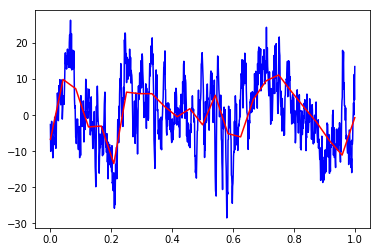

In [5]:
# Downsampling in time through FFT

t_sample = 25
X_train_sub = signal.resample(X_train,t_sample,axis=1)
if (N_val > 0): X_val_sub = signal.resample(X_val,t_sample,axis=1)
X_test_sub = signal.resample(X_test,t_sample,axis=1)

# show a downsampling example
plt.plot(np.linspace(0,1,T_train),X_train[5,:,5],'-b')
plt.plot(np.linspace(0,1,t_sample),X_train_sub[5,:,5],'-r')

In [6]:
print(X_train_sub.shape)

(2458, 25, 22)


In [7]:
# # normalize data across the time sequence dimension only
# scaler = preprocessing.MinMaxScaler()
# for i in range(N_train):
#     scaler.fit(X_train[i,:,:])
#     X_train[i,:,:] = scaler.transform(X_train[i,:,:])
    
# for i in range(N_val):
#     scaler.fit(X_val[i,:,:])
#     X_val[i,:,:] = scaler.transform(X_val[i,:,:])

In [8]:
# def downsample(data, mul=10, enableTrunc = False):
#     assert data.shape[0] % mul == 0 or  enableTrunc, "Can't downsample without data truncation.\
#                                                 \n Set another value of mul or set enableTrunc = True"
#     outdata = []
#     for i in range(data.shape[0]//mul):
#         outdata.append(np.mean(data[i*mul:(i+1)*mul,...], axis=0, keepdims=True))
#     outdata = reduce(lambda a,b: np.append(a,b,0), outdata)
    
#     return outdata
# span = 2
# X_train_sub = np.expand_dims(downsample(X_train[0,:,:], mul=span),axis=0)
# for n in np.arange(1,X_train.shape[0]):
#     X_train_sub = np.append(X_train_sub,
#                             np.expand_dims(downsample(X_train[n,:,:], mul=span),axis=0),axis=0)

# X_val_sub = np.expand_dims(downsample(X_val[0,:,:], mul=span),axis=0)
# for n in np.arange(1,X_val.shape[0]):
#     X_val_sub = np.append(X_val_sub,
#                             np.expand_dims(downsample(X_val[n,:,:], mul=span),axis=0),axis=0)

# print('X_train_sub: ', X_train_sub.shape)
# print('X_val_sub: ', X_val_sub.shape)

In [14]:
# Expected input shape: ([batch_size], timesteps, data_dim)
# Note that we have to provide the full batch_input_shape if the network is stateful.
# the sample of index i in batch k is the follow-up for the sample i in batch k-1.

# perhaps should try masking layer

data_dim = C_train
seq_split = 1 # Set to one when using FFT to down sample
seq_len = int(X_train_sub.shape[1]*seq_split)
timesteps = seq_len
num_classes = 4
batch_size = 200
num_epoch = 150

model = Sequential()
#1
model.add(GRU(200, return_sequences=True, stateful=False,
          recurrent_dropout=0.6, dropout = 0.6, input_shape=(timesteps, data_dim)))

#2
model.add(GRU(100, return_sequences=True, stateful=False,
          recurrent_dropout=0.6, dropout = 0.6))

#3
model.add(GRU(50, return_sequences=True, stateful=False,
          recurrent_dropout=0.6, dropout = 0.6))
model.add(Flatten())

#4
model.add(Dense(100))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(Dropout(0.5))

#5
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# define early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=70, mode='auto')

# saves the model weights after each epoch if the validation loss decreased
checkpointer = ModelCheckpoint(filepath='GRU_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True)

callbacks_list = [earlystop, checkpointer]

In [15]:
history = model.fit(X_train_sub[:,:seq_len,:], y_train,
                    batch_size=batch_size, epochs=num_epoch, shuffle=True,
                    validation_split = 0.15, callbacks=callbacks_list)

Train on 2089 samples, validate on 369 samples
Epoch 1/150
2089/2089 [==============================] - 4s 2ms/step - loss: 1.8444 - acc: 0.2676 - val_loss: 1.4085 - val_acc: 0.2683

Epoch 00001: val_acc improved from -inf to 0.26829, saving model to GRU_model.hdf5
Epoch 2/150
2089/2089 [==============================] - 2s 741us/step - loss: 1.7563 - acc: 0.2504 - val_loss: 1.3992 - val_acc: 0.2900

Epoch 00002: val_acc improved from 0.26829 to 0.28997, saving model to GRU_model.hdf5
Epoch 3/150
2089/2089 [==============================] - 2s 741us/step - loss: 1.7208 - acc: 0.2542 - val_loss: 1.4040 - val_acc: 0.3117

Epoch 00003: val_acc improved from 0.28997 to 0.31165, saving model to GRU_model.hdf5
Epoch 4/150
2089/2089 [==============================] - 2s 791us/step - loss: 1.6747 - acc: 0.2556 - val_loss: 1.3849 - val_acc: 0.3008

Epoch 00004: val_acc did not improve
Epoch 5/150
2089/2089 [==============================] - 2s 895us/step - loss: 1.6402 - acc: 0.2561 - val_loss:


Epoch 00044: val_acc did not improve
Epoch 45/150
2089/2089 [==============================] - 2s 828us/step - loss: 1.2883 - acc: 0.4011 - val_loss: 1.3575 - val_acc: 0.3659

Epoch 00045: val_acc did not improve
Epoch 46/150
2089/2089 [==============================] - 1s 618us/step - loss: 1.2910 - acc: 0.4026 - val_loss: 1.3563 - val_acc: 0.3821

Epoch 00046: val_acc did not improve
Epoch 47/150
2089/2089 [==============================] - 1s 717us/step - loss: 1.2855 - acc: 0.3964 - val_loss: 1.3541 - val_acc: 0.3848

Epoch 00047: val_acc did not improve
Epoch 48/150
2089/2089 [==============================] - 2s 770us/step - loss: 1.2919 - acc: 0.3906 - val_loss: 1.3360 - val_acc: 0.3875

Epoch 00048: val_acc did not improve
Epoch 49/150
2089/2089 [==============================] - 2s 828us/step - loss: 1.2902 - acc: 0.3968 - val_loss: 1.3395 - val_acc: 0.3767

Epoch 00049: val_acc did not improve
Epoch 50/150
2089/2089 [==============================] - 2s 875us/step - loss: 1.

2089/2089 [==============================] - 4s 2ms/step - loss: 1.2335 - acc: 0.4404 - val_loss: 1.2705 - val_acc: 0.4363

Epoch 00089: val_acc did not improve
Epoch 90/150
2089/2089 [==============================] - 5s 2ms/step - loss: 1.2186 - acc: 0.4490 - val_loss: 1.2617 - val_acc: 0.4390

Epoch 00090: val_acc did not improve
Epoch 91/150
2089/2089 [==============================] - 4s 2ms/step - loss: 1.1950 - acc: 0.4773 - val_loss: 1.2451 - val_acc: 0.4390

Epoch 00091: val_acc did not improve
Epoch 92/150
2089/2089 [==============================] - 4s 2ms/step - loss: 1.2141 - acc: 0.4476 - val_loss: 1.2572 - val_acc: 0.4390

Epoch 00092: val_acc did not improve
Epoch 93/150
2089/2089 [==============================] - 4s 2ms/step - loss: 1.2177 - acc: 0.4371 - val_loss: 1.2647 - val_acc: 0.4363

Epoch 00093: val_acc did not improve
Epoch 94/150
2089/2089 [==============================] - 3s 2ms/step - loss: 1.2100 - acc: 0.4610 - val_loss: 1.2676 - val_acc: 0.4553

Epoch 

2089/2089 [==============================] - 3s 1ms/step - loss: 1.1496 - acc: 0.4888 - val_loss: 1.3128 - val_acc: 0.4092

Epoch 00135: val_acc did not improve
Epoch 136/150
2089/2089 [==============================] - 3s 2ms/step - loss: 1.1200 - acc: 0.5141 - val_loss: 1.3098 - val_acc: 0.4173

Epoch 00136: val_acc did not improve
Epoch 137/150
2089/2089 [==============================] - 4s 2ms/step - loss: 1.1149 - acc: 0.5256 - val_loss: 1.3100 - val_acc: 0.4282

Epoch 00137: val_acc did not improve
Epoch 138/150
2089/2089 [==============================] - 4s 2ms/step - loss: 1.1365 - acc: 0.5127 - val_loss: 1.3028 - val_acc: 0.4336

Epoch 00138: val_acc did not improve
Epoch 139/150
2089/2089 [==============================] - 3s 2ms/step - loss: 1.1156 - acc: 0.5232 - val_loss: 1.2921 - val_acc: 0.4444

Epoch 00139: val_acc did not improve
Epoch 140/150
2089/2089 [==============================] - 4s 2ms/step - loss: 1.1166 - acc: 0.5112 - val_loss: 1.2919 - val_acc: 0.4390

E

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


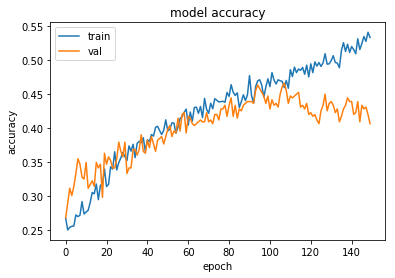

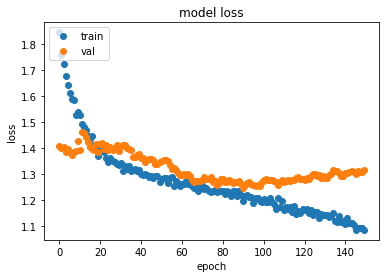

In [16]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'],'o')
plt.plot(history.history['val_loss'],'o')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [17]:
# evaluate model on entire training set
model = load_model('GRU_model.hdf5')
model.evaluate(X_train_sub,y_train,batch_size=N_train)

2458/2458 [==============================] - 2s 775us/step


[1.0252982378005981, 0.57323026657104492]

In [18]:
# evaluate model on test set
model.evaluate(X_test_sub,y_test,batch_size=N_test)

100/100 [==============================] - 0s 657us/step


[1.2396156787872314, 0.47999998927116394]